In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

# 1. Load Data

In [3]:
G1 = nx.read_gpickle("Data/Graphs/G1_bt.gpickle")
G2 = nx.read_gpickle("Data/Graphs/G2_bt.gpickle")

# 2. Variables

## 2.1. Response Variable

In [4]:
size_arr1 = np.array(list(nx.get_node_attributes(G1, 'fan_size').values()))  # Feb fan size
size_arr2 = np.array(list(nx.get_node_attributes(G2, 'fan_size').values()))  # Oct fan size

In [5]:
size_var = size_arr2 - size_arr1
size_var

array([   16, -5082,  1402, ...,   985,   585,     1])

In [6]:
size_var_binary = np.zeros(len(size_var), dtype = int)
size_var_binary[size_var > 0] = 1
size_var_binary

array([1, 0, 1, ..., 1, 1, 1])

## 2.2. Explanary Variables

### 2.2.1. Categorical Variables

In [7]:
def onehot_encoding(attribute_name, modification):
    d = nx.get_node_attributes(G1, attribute_name)
    new_d = {}
    if modification:
        for k,v in d.items():
            if v not in modification:
                d[k] = "None"
    
    ## trial
    label_list = []
    
    for name in set(d.values()):
        keys_with_name = [i for i in d if d[i]== name]
        label = np.zeros(len(G1.nodes), dtype = int)
        i = 0
        for node in G1.nodes:
            if node in keys_with_name:
                label[i] = 1
            i += 1
        
        label_list.append(label)
    
    return np.transpose(np.array(label_list))

1. polarity: $p_i$

In [8]:
polarity_encoding = onehot_encoding('polarity', None)
polarity_encoding

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

2. community detection: $c_i$

In [9]:
comm_encoding = onehot_encoding('infomap_comm', None)
comm_encoding

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

3. Within-group Bow-tie Roles / Across-group Bow-tie Roles: $\textit{W-BT}_i$, $\textit{A-BT}_i$

In [10]:
within_role_encoding = onehot_encoding('within_role', ['S', 'IN', 'OUT'])
within_role_encoding

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [1, 0, 0, 0]])

In [11]:
across_role_encoding = onehot_encoding('across_role', ['S', 'IN', 'OUT'])
across_role_encoding

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       ...,
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

### 2.2.2. Numeric Variables

1. Feb fan size: $f_i$

In [12]:
size_arr1

array([   78,  5082, 20773, ...,     0,  2387,   345])

In [13]:
size_arr1 = np.log(size_arr1 + 1)

2. Weighted in-degree/out-degree: $k_i^{in}$, $k_i^{out}$ 

In [14]:
IN_degree1 = np.array(list(dict(G1.in_degree(weight = "weight")).values()))
IN_degree1

array([         0,          0, 3694623461, ...,          0,   44102212,
                0])

In [15]:
OUT_degree1 = np.array(list(dict(G1.out_degree(weight = "weight")).values()))
OUT_degree1

array([        0,         0,         0, ...,         0, 323658104,
        83321295])

3. Proportion of IN/OUT Degree with the same polairty (the proportion of the recommendation strength from (to) pages with the same polarity as page i, out of all the accumulated recommedations made to (by) page i by Feb): $\textit{k-PS}_i^{in}$, $\textit{k-PS}_i^{out}$

In [16]:
def degree_proportion_polarity(count_same = True):
    count_in_arr = np.zeros(len(G1.nodes)); count_out_arr = np.zeros(len(G1.nodes))
    index = 0
    for node in G1.nodes:
        # IN
        for edge in G1.in_edges(node):
            if edge[0].startswith(node[0]) and count_same:
                count_in_arr[index] += G1.edges[edge]["weight"]
            elif not edge[0].startswith(node[0]) and not count_same:
                count_in_arr[index] += G1.edges[edge]["weight"]
               
        if IN_degree1[index] != 0:
            count_in_arr[index] = count_in_arr[index]/IN_degree1[index]
        
        # OUT
        for edge in G1.out_edges(node):
            if edge[1].startswith(node[0]) and count_same:
                count_out_arr[index] += G1.edges[edge]["weight"]
            elif not edge[1].startswith(node[0]) and not count_same:
                count_out_arr[index] += G1.edges[edge]["weight"]
        
        if OUT_degree1[index] != 0:
            count_out_arr[index] = count_out_arr[index]/OUT_degree1[index]
        
        index += 1
        
    return count_in_arr, count_out_arr

In [17]:
IN_degree_same_p1, OUT_degree_same_p1 = degree_proportion_polarity(count_same = True)

- Further Explorations: Why not consider different polarity?

    For anti-vaccine and pro-vaccine pages, there are only a small number of interactions between anti-vaccine pages and pro-vaccine pages. Neutral pages usually demonstrate strong proximity to either anti-vaccine or pro-vaccine pages. Therefore, if we consider the proportion of IN/OUT Degree with a different polairty to these pages, then these values will approximate 1 - IN/OUT Degree with the same polairty, representing interactions between anti-vaccine/prov-vaccine pages and neutral pages.

In [18]:
import pandas as pd
def indegree_behavior():
    count_in_dict = {node:[0, 0, 0, 0, 0] for node in list(G1.nodes) if dict(G1.in_degree(weight = "weight"))[node] != 0}
    for node in count_in_dict.keys():
        # IN
        count_in_dict[node][3] = max(np.log(dict(G1.in_degree(weight = "weight"))[node]) - 15, 0.5)
        for edge in G1.in_edges(node):
            if edge[0].startswith('a'):
                count_in_dict[node][0] += G1.edges[edge]["weight"]
            elif edge[0].startswith('p'):
                count_in_dict[node][1] += G1.edges[edge]["weight"]
            else:
                count_in_dict[node][2] += G1.edges[edge]["weight"]
        if node.startswith('a'):
            count_in_dict[node][4] = 'anti'
        elif node.startswith('p'):
            count_in_dict[node][4] = 'pro'
        else:
            count_in_dict[node][4] = 'neutral'
    return pd.DataFrame.from_dict(count_in_dict, orient='index', columns=['anti', 'pro', 'neutral', 'total', 'polarity'])

In [19]:
IN_behavior = indegree_behavior()

In [20]:
import plotly.express as px

fig = px.scatter_ternary(IN_behavior, a = "neutral", b="anti", c="pro", size = "total", hover_name = IN_behavior.index,
                        color="polarity", color_discrete_map = {"anti": "red", "pro": "blue", "neutral":"green"})
#fig.update_traces(marker={'size': 10})
fig.update_layout(font = dict(size = 30))
fig.show()

In [21]:
def outdegree_behavior():
    count_out_dict = {node:[0, 0, 0, 0, 0] for node in list(G1.nodes) if dict(G1.out_degree(weight = "weight"))[node] != 0}
    for node in count_out_dict.keys():
        # IN
        count_out_dict[node][3] = max(np.log(dict(G1.out_degree(weight = "weight"))[node]) - 15, 0.5)
        for edge in G1.out_edges(node):
            if edge[1].startswith('a'):
                count_out_dict[node][0] += G1.edges[edge]["weight"]
            elif edge[1].startswith('p'):
                count_out_dict[node][1] += G1.edges[edge]["weight"]
            else:
                count_out_dict[node][2] += G1.edges[edge]["weight"]
        if node.startswith('a'):
            count_out_dict[node][4] = 'anti'
        elif node.startswith('p'):
            count_out_dict[node][4] = 'pro'
        else:
            count_out_dict[node][4] = 'neutral'
    return pd.DataFrame.from_dict(count_out_dict, orient='index', columns=['anti', 'pro', 'neutral', 'total', 'polarity'])

In [22]:
OUT_behavior = outdegree_behavior()

In [23]:
fig = px.scatter_ternary(OUT_behavior, a = "neutral", b="anti", c="pro", size = "total", hover_name = OUT_behavior.index, 
                        color="polarity", color_discrete_map = {"anti": "red", "pro": "blue", "neutral":"green"})
#fig.update_traces(marker={'size': 10})
fig.update_layout(font = dict(size = 30))
fig.show()

4. Proportion of IN/OUT Degree with the same community (the proportion of the recommendation strength from (to) pages with the same community as page i, out of all the accumulated recommedations made to (by) page i by Feb): $\textit{k-CS}_i^{in}$, $\textit{k-CS}_i^{out}$

In [24]:
def degree_proportion_community():
    count_in_arr = np.zeros(len(G1.nodes)); count_out_arr = np.zeros(len(G1.nodes))
    index = 0
    for node in G1.nodes:
        # IN
        for edge in G1.in_edges(node):
            if G1.nodes[edge[0]]['infomap_comm'] ==  G1.nodes[edge[1]]['infomap_comm']:
                count_in_arr[index] += G1.edges[edge]["weight"]
               
        if IN_degree1[index] != 0:
            count_in_arr[index] = count_in_arr[index]/IN_degree1[index]
        
        # OUT
        for edge in G1.out_edges(node):
            if G1.nodes[edge[0]]['infomap_comm'] ==  G1.nodes[edge[1]]['infomap_comm']:
                count_out_arr[index] += G1.edges[edge]["weight"]
        
        if OUT_degree1[index] != 0:
            count_out_arr[index] = count_out_arr[index]/OUT_degree1[index]
        
        index += 1
        
    return count_in_arr, count_out_arr

In [25]:
IN_degree_same_c1, OUT_degree_same_c1 = degree_proportion_community()

5. PageRank

In [26]:
pagerank1 = np.array(list(dict(nx.pagerank(G1)).values()))
pagerank1

array([0.00027672, 0.00027672, 0.00038473, ..., 0.00027672, 0.00028041,
       0.00027672])

6. Betweeness

In [27]:
betweenness1 = np.array(list(dict(nx.betweenness_centrality(G1)).values()))
betweenness1

array([0.        , 0.        , 0.        , ..., 0.00094113, 0.00011807,
       0.        ])

# 3. ML for All Features

In [28]:
features = np.hstack((size_arr1.reshape(-1,1), IN_degree1.reshape(-1,1), OUT_degree1.reshape(-1,1), IN_degree_same_p1.reshape(-1,1), OUT_degree_same_p1.reshape(-1,1),IN_degree_same_c1.reshape(-1,1), OUT_degree_same_c1.reshape(-1,1), pagerank1.reshape(-1,1), betweenness1.reshape(-1,1), polarity_encoding, comm_encoding, within_role_encoding, across_role_encoding))

In [29]:
ap_index = list(np.arange(0, 317, 1)) + list(np.arange(1202, len(G1.nodes), 1))

In [30]:
ap_features = features[ap_index,:]
ap_size_var = size_var[ap_index]
ap_size_var_binary = size_var_binary[ap_index]

In [31]:
np.shape(ap_features), np.shape(ap_size_var), np.shape(ap_size_var_binary)

((441, 192), (441,), (441,))

In [32]:
np.sum(ap_size_var_binary) / len(ap_size_var_binary)

0.7301587301587301

## 3.1. Logistic Regression

### 3.1.1. Search for the best parameters

In [33]:
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [34]:
# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    "lgr__class_weight": ['balanced'],
    "lgr__penalty": ['l1', 'l2', 'elasticnet'],
    "lgr__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "lgr__intercept_scaling": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "lgr__solver": ["liblinear", "saga"],
    "lgr__max_iter": [10000],
    "lgr__random_state": [1, 2, 3]
}

In [35]:
def search_parameters(f, print_result = False):
    scaler = StandardScaler()
    lgr = LogisticRegression()
    pipe = Pipeline(steps=[("scaler", scaler), ("lgr", lgr)])
    
    cv = KFold(n_splits = 5, shuffle = True)
    search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv = cv, scoring  = 'accuracy')
    search.fit(f, ap_size_var_binary)
    
    if print_result:
        print("Best parameter (CV score=%0.3f):" % search.best_score_)
        print(search.best_params_)
        
    return search.best_params_

### 3.1.2. Results

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
def get_SPC(Yv, Yv_pred):
    cm = confusion_matrix(Yv,Yv_pred)
    tp = cm[1, 1]
    tn = cm[0, 0]
    fn = cm[1, 0]
    fp = cm[0, 1]
    
    return tn / (tn + fp)

In [38]:
from sklearn.model_selection import KFold
import matplotlib.patches as mpatches
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score

def reg_eval(clf, X, Y):
    """
    clf: type of classifier
    X: training data provided, to be exact it is the combination of training and validation data
    Y: corresponding label of X
    """

    kf = KFold(n_splits = 5, shuffle = True)
    cm_sum = np.zeros((2,2), dtype = int)
    pred_prob = []; size_var_corresponding = []
    recall_score_list = np.zeros(5); SPC_score_list = np.zeros(5); accuracy_list = np.zeros(5)
    
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        Xtr, Xv = X[train_index], X[test_index]
        Ytr, Yv = Y[train_index], Y[test_index]
        clf.fit(Xtr,Ytr)
        
        Yv_pred = clf.predict(Xv)
        
        #print(recall_score(Yv, Yv_pred))
        #print(get_SPC(Yv, Yv_pred))
        #print(clf.score(Xv, Yv))
        
        recall_score_list[i] = recall_score(Yv, Yv_pred)
        SPC_score_list[i] = get_SPC(Yv, Yv_pred)
        accuracy_list[i] = clf.score(Xv, Yv)
        
    
        cm = confusion_matrix(Yv,Yv_pred)
        cm_sum += cm
        
        pred_prob += list(clf.predict_proba(Xv))
        #print(clf.classes_)
        size_var_corresponding += list(ap_size_var[test_index])
        
        #fig, ax = plt.subplots(figsize=(3, 3))
        #ax.imshow(cm)
        #ax.grid(False)
        #ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
        #ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
        #ax.set_ylim(1.5, -0.5)
        #for i in range(2):
        #    for j in range(2):
        #        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
        #plt.show()
    
    print(cm_sum)
    print(np.average(recall_score_list), np.average(SPC_score_list), np.average(accuracy_list))
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    pred_prob = np.array(pred_prob)[:, 1]
    size_var_corresponding = np.array(size_var_corresponding)
    axs[0].hist(pred_prob[size_var_corresponding > 0], label = "Ground Truth: Expanding", alpha = 0.5)
    axs[0].hist(pred_prob[size_var_corresponding <= 0], label = "Ground Truth: Non-expanding", alpha = 0.5)                     
    axs[0].set_title("Histogram of Expanding Probabilty (labelled 1)")
    axs[0].legend()
    
    axs[1].scatter(pred_prob, size_var_corresponding)
    axs[1].set_xlabel("Predicted Probability of Expanding")
    axs[1].set_ylabel("Fan Size Var")
    axs[1].set_yscale('symlog')
    
    return pred_prob

In [44]:
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier

def parameter_reg_eval(f):
    
    print("Random:")
    random_classifier = reg_eval(DummyClassifier(strategy='uniform'), f, ap_size_var_binary)
    
    best_parameter = search_parameters(f, print_result = True)
    
    regressor = make_pipeline(StandardScaler(), 
                              LogisticRegression(class_weight = best_parameter["lgr__class_weight"],
                                                 C = best_parameter["lgr__C"], 
                                                 intercept_scaling = best_parameter["lgr__intercept_scaling"], 
                                                 penalty = best_parameter["lgr__penalty"], 
                                                 solver = best_parameter["lgr__solver"], 
                                                 max_iter = best_parameter["lgr__max_iter"], 
                                                 random_state = best_parameter["lgr__random_state"]))
    
    
    print("Logistic:")
    pred_prob = reg_eval(regressor, f, ap_size_var_binary)
    
    return pred_prob

Random:
[[ 63  56]
 [164 158]]
0.4899783370751113 0.5247585779759693 0.5169050051072522
Best parameter (CV score=0.648):
{'lgr__C': 0.1, 'lgr__class_weight': 'balanced', 'lgr__intercept_scaling': 0.001, 'lgr__max_iter': 10000, 'lgr__penalty': 'l1', 'lgr__random_state': 1, 'lgr__solver': 'saga'}
Logistic:
[[ 19 100]
 [ 52 270]]
0.8391919275455763 0.152991452991453 0.6552860061287028


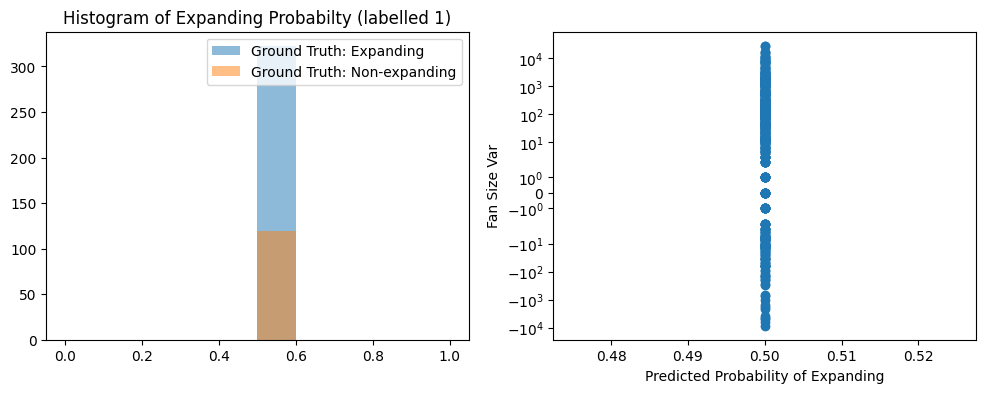

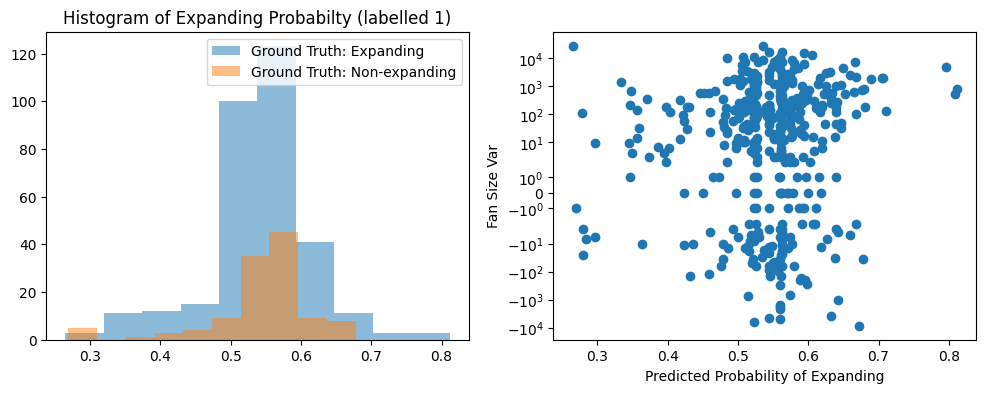

In [45]:
pred_prob = parameter_reg_eval(ap_features)

## 3.2. SVR & RFR

### 3.2.1. Search for the best parameters

In [149]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [150]:
svr_param_grid = {
    "svr__kernel": ['linear', 'poly', 'rbf', 'sigmond'],
    "svr__C": [0.1, 1, 10, 100, 1000],
    "svr__epsilon": [0.1, 1, 10, 100, 1000]
}

In [151]:
rfg_param_grid = {
    "rfg__n_estimators": [1, 10, 100, 1000],
    #"rfg__criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
    "rfg__criterion": ["squared_error", "friedman_mse"],
    "rfg__max_features": [1, "sqrt", "log2", None]
}

In [152]:
def search_parameters(f, data_index, model, print_result = False):
    
    scaler = StandardScaler()
    
    if model == 'svr':
        svr = SVR()
        pipe = Pipeline(steps=[("scaler", scaler), ("svr", svr)])
        param_grid = svr_param_grid
        
    elif model == 'rfg':
        rfg = RandomForestRegressor()
        pipe = Pipeline(steps=[("scaler", scaler), ("rfg", rfg)])
        param_grid = rfg_param_grid
    
    cv = KFold(n_splits = 5, shuffle = True)
    search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv = cv, scoring  = 'neg_mean_absolute_error')
    search.fit(f[data_index, :], size_var[data_index])
    
    if print_result:
        print("Best parameter (CV score=%0.3f):" % search.best_score_)
        print(search.best_params_)
        
    return search.best_params_

### 3.2.2. Results

In [153]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_metric(Y, Y_pred, choice):
    if choice == "MAE":
        return mean_absolute_error(Y, Y_pred)
    if choice == "RMSE":
        return math.sqrt(np.square(np.subtract(Y, Y_pred)).mean())
    if choice == "R2":
        return r2_score(Y, Y_pred)

In [154]:
def get_colour(index_arr):
    colour_arr = np.array(['red'] * 317 + ['green'] * 885 + ['blue'] * 124)
    return colour_arr[index_arr]

In [155]:
from sklearn.model_selection import KFold
import matplotlib.patches as mpatches

def reg_eval(clf, f, data_index):
    """
    clf: type of classifier
    X: training data provided, to be exact it is the combination of training and validation data
    Y: corresponding label of X
    """
    
    X = f[data_index, :]
    Y = size_var[data_index]

    kf = KFold(n_splits = 5, shuffle = True)
    
    R2_eval_result = np.zeros(5); R2_bl_eval_result = np.zeros(5); 
    MAE_eval_result = np.zeros(5); MAE_bl_eval_result = np.zeros(5); 
    RMSE_eval_result = np.zeros(5); RMSE_bl_eval_result = np.zeros(5); 
    
    counter = 0
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        Xtr, Xv = X[train_index], X[test_index]
        Ytr, Yv = Y[train_index], Y[test_index]
        clf.fit(Xtr,Ytr)
        Yv_pred = clf.predict(Xv) 
        
        #simply test
        #test_index = train_index
        #Yv = Ytr
        #Yv_pred = clf.predict(Xtr)
        
        axs[0].scatter(Yv, Yv_pred, label = "Folder " + str(counter+1))
        axs[0].plot(Yv, Yv, c = 'k')
        axs[0].set_xscale('symlog'); axs[0].set_yscale("symlog");
        axs[0].set_xlabel('Fan Size Variation'); axs[0].set_ylabel('Predicted Fan Size Variation')
        axs[0].legend()
        
        axs[1].scatter((Xv[:, 0] + Yv), Yv_pred, label = "Folder " + str(counter+1))
        axs[1].set_xscale('symlog'); axs[1].set_yscale("symlog");
        axs[1].set_xlabel('Fan Size (Feb)'); axs[1].set_ylabel('Predicted Fan Size Variation')
        axs[1].legend()
        
        axs[2].scatter((Xv[:, 0] + Yv), Yv_pred, color = get_colour(data_index[test_index]))
        axs[2].set_xscale('symlog'); axs[2].set_yscale("symlog");
        axs[2].set_xlabel('Fan Size (Feb)'); axs[2].set_ylabel('Predicted Fan Size Variation')
        
        red_patch = mpatches.Patch(color='red', label='antivax')
        blue_patch = mpatches.Patch(color='blue', label='provax')
        green_patch = mpatches.Patch(color='green', label='neutral')
        axs[2].legend(handles=[red_patch, blue_patch, green_patch])
        
        
        R2_eval_result[counter] = eval_metric(Y[test_index], Yv_pred, "R2")
        R2_bl_eval_result[counter] = eval_metric(Y[test_index], np.array([np.mean(Y[train_index])] * len(test_index)), "R2")
        
        MAE_eval_result[counter] = eval_metric(Y[test_index], Yv_pred, "MAE")
        MAE_bl_eval_result[counter] = eval_metric(Y[test_index], np.array([np.mean(Y[train_index])] * len(test_index)), "MAE")
        
        RMSE_eval_result[counter] = eval_metric(Y[test_index], Yv_pred, "RMSE")
        RMSE_bl_eval_result[counter] = eval_metric(Y[test_index], np.array([np.mean(Y[train_index])] * len(test_index)), "RMSE")
        
        counter += 1
    
    
    table = np.vstack((R2_eval_result, R2_bl_eval_result, MAE_eval_result, MAE_bl_eval_result, RMSE_eval_result, RMSE_bl_eval_result)); table = np.transpose(table)
    mean = np.mean(table, axis = 0); std = np.std(table, axis = 0)
    
    table = np.vstack((table, mean, std))
    header_row=["R2", "R2_Baseline", "MAE", "MAE_Baseline", "RMSE", "RMSE_Baseline"] 
    header_col=["Folder 1", "Folder 2", "Folder 3", "Folder4", "Folder5", "Mean", "SD"] 
    df = pd.DataFrame(table, header_col, header_row)
    display(df)

In [156]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def parameter_reg_eval(f, model):
    
    
    label_list = ['All Pages: ', 'Expanding Pages: ', 'Non-expanding Pages: ']
    all_bool = [True] * len(ap_size_var)
    expand_bool = ap_size_var > 0
    non_expand_bool = ap_size_var <= 0
    index = np.array(list(np.arange(0, 317, 1)) + list(np.arange(1202, len(G1.nodes), 1))); index_list = [index[b] for b in [all_bool, expand_bool, non_expand_bool]]
    
    for i in range(3):
        print(label_list[i])
        
        best_parameter = search_parameters(f, index_list[i], model, print_result = True)
    
        if model == 'svr':
             regressor = make_pipeline(StandardScaler(), 
                                       SVR(kernel = best_parameter["svr__kernel"],
                                           C = best_parameter["svr__C"], 
                                           epsilon = best_parameter["svr__epsilon"]))
        
        elif model == 'rfg':
            regressor = make_pipeline(StandardScaler(), 
                                      RandomForestRegressor(n_estimators = best_parameter["rfg__n_estimators"], 
                                                            criterion = best_parameter["rfg__criterion"], 
                                                            max_features = best_parameter["rfg__max_features"]))
        
        
        
        reg_eval(regressor, f, index_list[i])
        print("")
        
    return

All Pages: 
Best parameter (CV score=-980.512):
{'svr__C': 10, 'svr__epsilon': 10, 'svr__kernel': 'linear'}


R2  R2_Baseline          MAE  MAE_Baseline         RMSE  \
Folder 1  0.010604    -0.002855  1270.791115   1592.936287  3648.709279   
Folder 2  0.088507    -0.019800  1165.216521   1589.748745  3510.400592   
Folder 3 -0.041939    -0.080631   775.873532   1192.158801  1790.393224   
Folder4   0.169705    -0.019843   885.004886   1289.095384  2336.150240   
Folder5   0.088135    -0.003797   847.856589   1263.669618  2233.784577   
Mean      0.063002    -0.025385   988.948529   1385.521767  2703.887582   
SD        0.072699     0.028593   193.193074    171.034892   739.439085   

          RMSE_Baseline  
Folder 1    3673.442827  
Folder 2    3713.107454  
Folder 3    1823.332859  
Folder4     2589.113197  
Folder5     2343.682981  
Mean        2828.535864  
SD           748.220995


Expanding Pages: 
Best parameter (CV score=-1118.269):
{'svr__C': 10, 'svr__epsilon': 100, 'svr__kernel': 'linear'}


R2  R2_Baseline          MAE  MAE_Baseline         RMSE  \
Folder 1  0.090288    -0.003423  1354.557784   1944.941395  4141.567575   
Folder 2  0.033166    -0.021015  1569.616753   2046.824903  4061.179861   
Folder 3  0.056501    -0.023356   960.501977   1433.895228  1935.576335   
Folder4   0.232710    -0.019035   882.791698   1547.314075  2252.201210   
Folder5   0.108722    -0.008292   969.016108   1477.660610  2109.776958   
Mean      0.104277    -0.015024  1147.296864   1690.127242  2900.060388   
SD        0.069354     0.007763   267.563270    254.305324   986.310035   

          RMSE_Baseline  
Folder 1    4349.654997  
Folder 2    4173.422401  
Folder 3    2015.825672  
Folder4     2595.504819  
Folder5     2244.002111  
Mean        3075.682000  
SD           987.278905


Non-expanding Pages: 
Best parameter (CV score=-315.725):
{'svr__C': 1, 'svr__epsilon': 1, 'svr__kernel': 'linear'}


R2  R2_Baseline         MAE  MAE_Baseline         RMSE  \
Folder 1 -0.024121    -0.028785  200.282626    493.161404   899.327174   
Folder 2  0.058769    -0.136757  163.773711    410.398246   464.287656   
Folder 3 -0.078669    -0.042145  641.108816    806.575439  2030.853667   
Folder4  -0.032492    -0.000682  298.514506    533.758333  1282.616938   
Folder5  -0.068352    -0.002409  275.947205    509.401721   885.164096   
Mean     -0.028973    -0.042156  315.925373    550.659028  1112.449906   
SD        0.048487     0.049856  169.805204    134.506559   527.184356   

          RMSE_Baseline  
Folder 1     901.372913  
Folder 2     510.237881  
Folder 3    1996.174621  
Folder4     1262.704770  
Folder5      857.411115  
Mean        1105.580260  
SD           505.087624

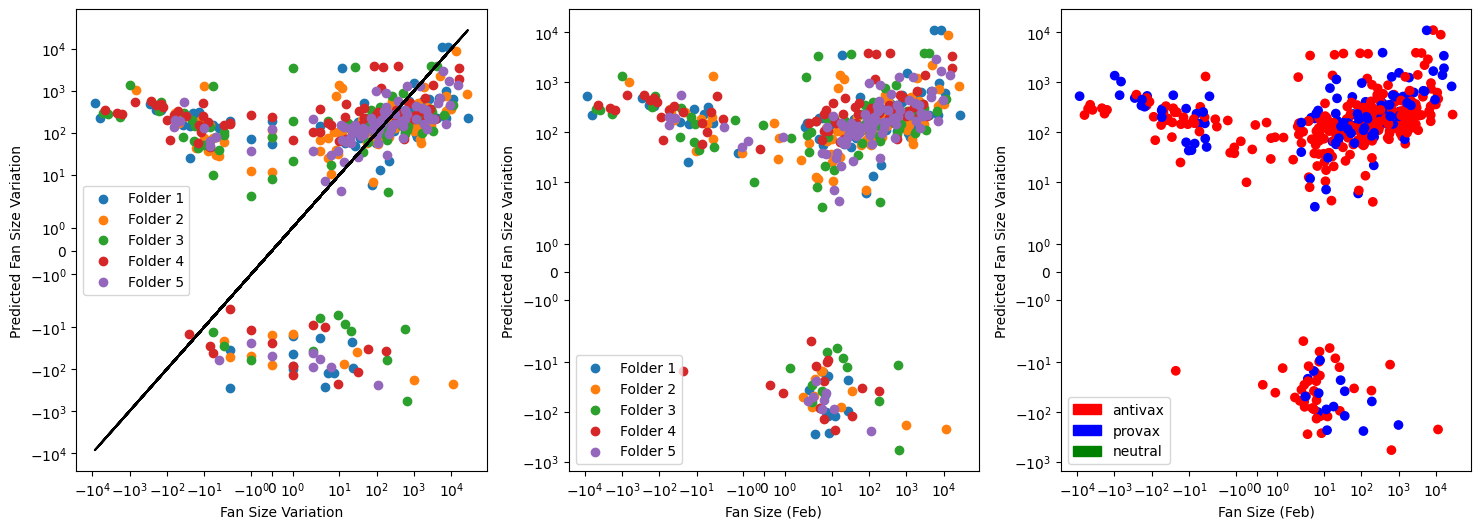

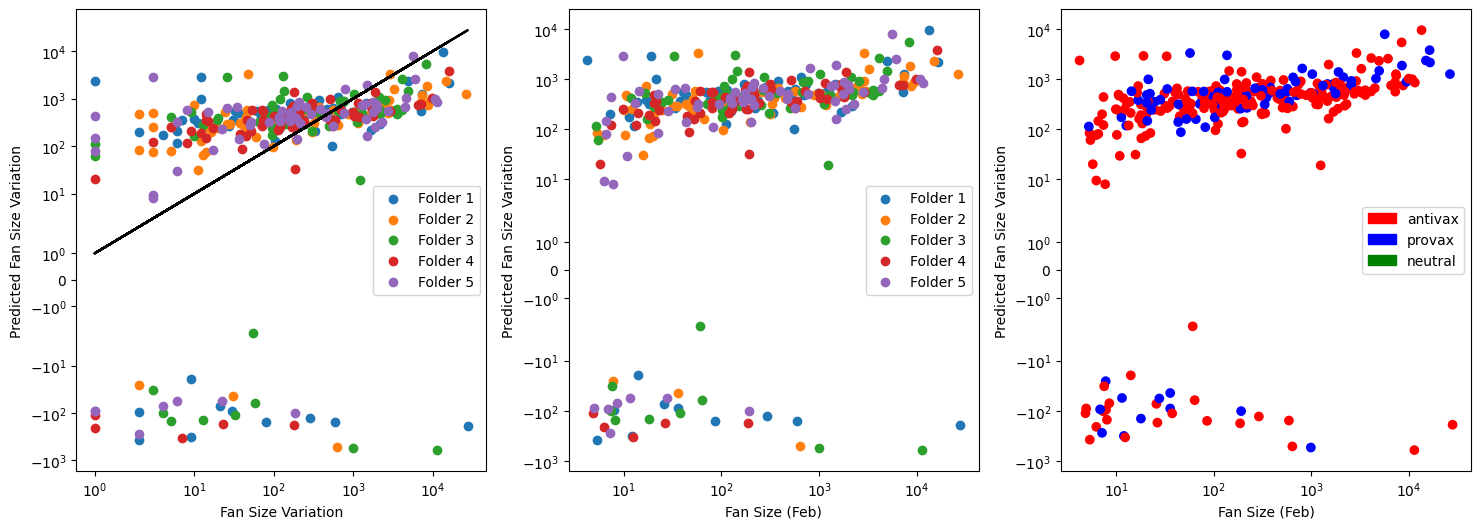

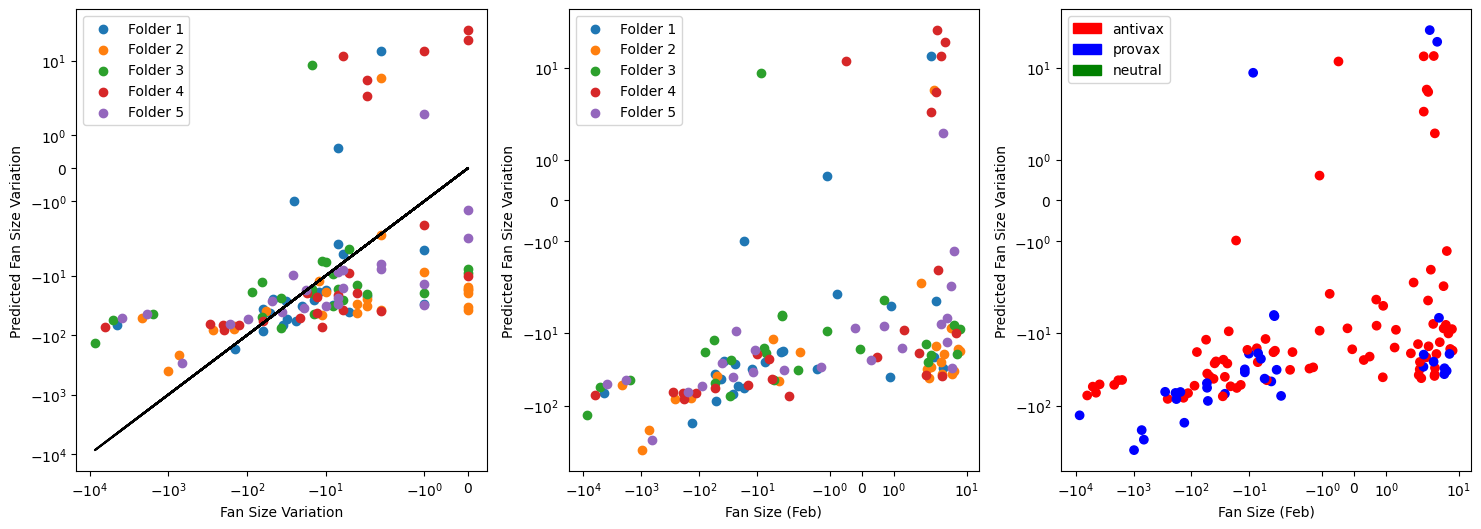

In [196]:
parameter_reg_eval(features, 'svr')

All Pages: 
Best parameter (CV score=-990.116):
{'rfg__criterion': 'squared_error', 'rfg__max_features': None, 'rfg__n_estimators': 10}


R2  R2_Baseline          MAE  MAE_Baseline         RMSE  \
Folder 1 -0.114084    -0.016904  1388.495506   1639.444171  3498.298464   
Folder 2  0.065875    -0.000126  1143.621591   1480.534606  3516.844174   
Folder 3  0.406960    -0.011253   669.622727   1090.362381  1456.368101   
Folder4  -0.685539    -0.029771  1229.470455   1375.462143  2718.598494   
Folder5   0.242993    -0.000736   989.069318   1319.015033  2772.684840   
Mean     -0.016759    -0.011758  1084.055919   1380.963667  2792.558815   
SD        0.376982     0.011027   244.194285    181.682993   750.190437   

          RMSE_Baseline  
Folder 1    3342.241348  
Folder 2    3638.966278  
Folder 3    1901.775027  
Folder4     2124.936454  
Folder5     3187.941721  
Mean        2839.172166  
SD           693.287167


Expanding Pages: 
Best parameter (CV score=-1091.814):
{'rfg__criterion': 'squared_error', 'rfg__max_features': None, 'rfg__n_estimators': 100}


R2  R2_Baseline          MAE  MAE_Baseline         RMSE  \
Folder 1  0.303442    -0.085747  1755.785538   2671.192817  4576.688921   
Folder 2 -0.451171    -0.021568  1281.724462   1581.023406  3186.874464   
Folder 3  0.269337    -0.083461   866.346406   1444.907461  1696.852649   
Folder4   0.573193    -0.008621   914.548281   1460.736192  1573.790949   
Folder5   0.165180    -0.063539   817.582813   1368.336967  1574.279916   
Mean      0.171996    -0.052587  1127.197500   1705.239369  2521.697380   
SD        0.339439     0.031837   354.436381    487.760885  1195.152381   

          RMSE_Baseline  
Folder 1    5713.958463  
Folder 2    2673.864119  
Folder 3    2066.295107  
Folder4     2419.329292  
Folder5     1776.896099  
Mean        2930.068616  
SD          1424.952603


Non-expanding Pages: 
Best parameter (CV score=-234.182):
{'rfg__criterion': 'squared_error', 'rfg__max_features': 'sqrt', 'rfg__n_estimators': 1}


R2  R2_Baseline         MAE  MAE_Baseline         RMSE  \
Folder 1 -0.054272    -0.001539  307.000000    550.076754  1297.448875   
Folder 2 -0.217881    -0.018823  597.541667    655.495175  1900.202325   
Folder 3  0.046453    -0.423098  108.791667    403.247807   378.121288   
Folder4  -0.484106   -42.062866   35.750000    382.667982    71.879529   
Folder5  -0.209055    -0.090769  715.086957    811.796196  1687.902699   
Mean     -0.183772    -8.519419  352.834058    560.656783  1067.110943   
SD        0.179876    16.772417  265.822770    160.396297   720.787282   

          RMSE_Baseline  
Folder 1    1264.584413  
Folder 2    1737.988772  
Folder 3     461.931325  
Folder4      387.190026  
Folder5     1603.211831  
Mean        1090.981273  
SD           566.067638

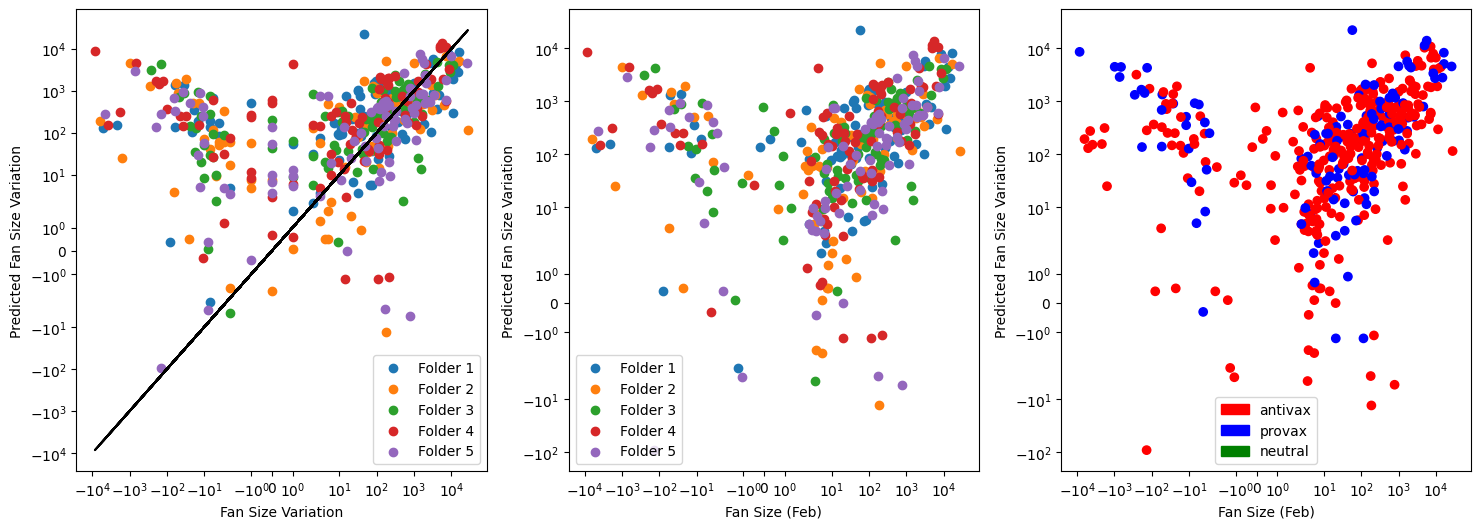

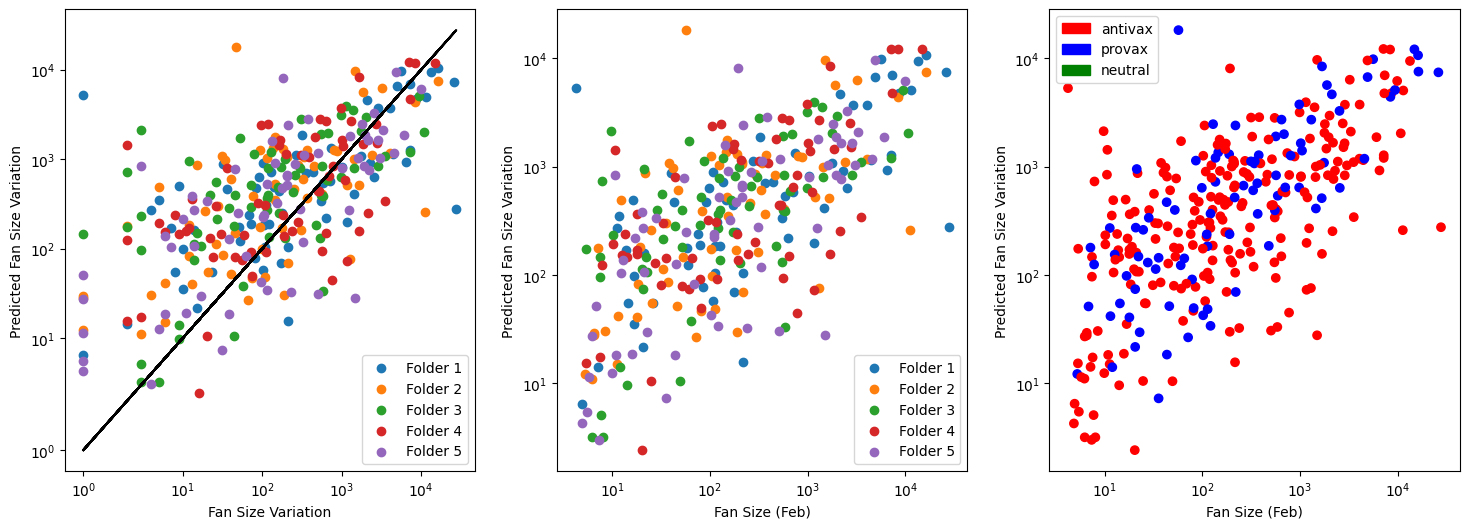

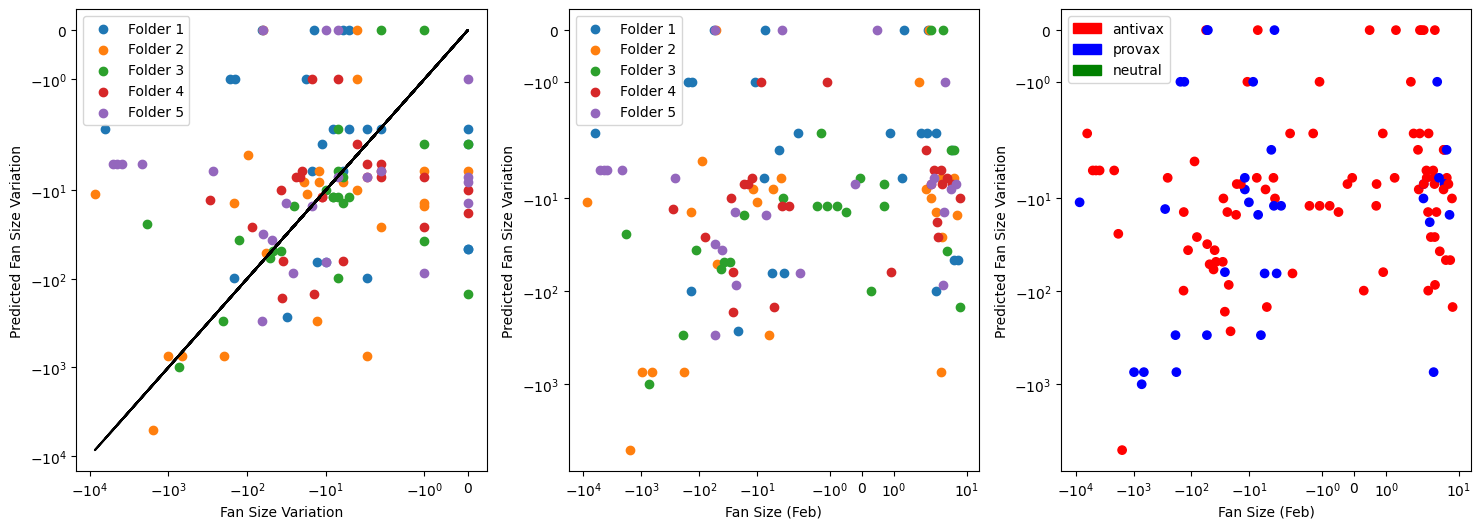

In [194]:
parameter_reg_eval(features, 'rfg')

# 4. Feature Selection

In [35]:
cont_features = np.hstack((size_arr1.reshape(-1,1), IN_degree1.reshape(-1,1), OUT_degree1.reshape(-1,1), IN_degree_same_p1.reshape(-1,1), OUT_degree_same_p1.reshape(-1,1),IN_degree_same_c1.reshape(-1,1), OUT_degree_same_c1.reshape(-1,1), pagerank1.reshape(-1,1), betweenness1.reshape(-1,1)))

In [36]:
def ordinal_encoding(attribute_name, modification):
    d = nx.get_node_attributes(G1, attribute_name)
    if modification:
        for k,v in d.items():
            if v not in modification:
                d[k] = "None"
    
    label_arr = np.zeros(len(G1.nodes), dtype = int)
    
    name_counter = 0 
    for name in set(d.values()):
        i = 0
        for node in G1.nodes:
            if d[node] == name:
                label_arr[i] = name_counter
            i += 1
        name_counter += 1
    
    return label_arr

In [37]:
polarity_ordinal_encoding = ordinal_encoding('polarity', None)
polarity_ordinal_encoding

array([2, 2, 2, ..., 1, 1, 1])

In [38]:
comm_ordinal_encoding = ordinal_encoding('infomap_comm', None)
comm_ordinal_encoding

array([ 74,  87,  85, ..., 117,  29, 127])

In [39]:
within_role_ordinal_encoding = ordinal_encoding('within_role', ['S', 'IN', 'OUT'])
within_role_ordinal_encoding 

array([1, 1, 0, ..., 2, 0, 3])

In [40]:
across_role_ordinal_encoding = ordinal_encoding('across_role', ['S', 'IN', 'OUT'])

In [41]:
disc_features = np.hstack((polarity_ordinal_encoding.reshape(-1, 1), comm_ordinal_encoding.reshape(-1, 1), within_role_ordinal_encoding.reshape(-1, 1), across_role_ordinal_encoding.reshape(-1, 1)))

In [42]:
ap_cont_features = cont_features[ap_index,:]

In [43]:
np.shape(disc_features)

(1326, 4)

In [44]:
ap_disc_features = disc_features[ap_index,:]

In [45]:
np.shape(ap_cont_features)

(441, 9)

In [46]:
np.shape(ap_disc_features)

(441, 4)

## 4.1. CC & MI

- **CC (for cont. features only)**

In [88]:
def cal_corr(features, target):
    corr_arr = np.zeros(np.shape(features)[1])
    for i in range(len(corr_arr)):
        corr_arr[i] = np.corrcoef(target, features[:,i])[0,1]
    return corr_arr

In [89]:
cal_corr(ap_cont_features, ap_size_var)

array([ 0.37884337,  0.40581591,  0.25398165, -0.03887074, -0.07766889,
        0.09074343,  0.05237609,  0.25228703,  0.14160476])

In [95]:
cal_corr(ap_cont_features[ap_size_var > 0, :], ap_size_var[ap_size_var > 0])

array([ 0.48461624,  0.41609879,  0.26284538, -0.10653174, -0.13687571,
        0.05250272,  0.04406143,  0.25837   ,  0.12708199])

In [96]:
cal_corr(ap_cont_features[ap_size_var <= 0, :], ap_size_var[ap_size_var <= 0])

array([-0.37233668, -0.0361757 , -0.26669104,  0.2373699 ,  0.1446523 ,
        0.27513954,  0.07448312, -0.03215579,  0.03248983])

- **MI**

In [128]:
from sklearn.feature_selection import mutual_info_regression

def cal_mutual_info_reg(features, target, discrete, times):
    dataset = []
    
    for i in range(times):
        #print(i)
        MI = mutual_info_regression(features, target, discrete_features = discrete)
        dataset.append(MI)
        
    return np.average(np.array(dataset), axis = 0)

In [129]:
cal_mutual_info_reg(ap_disc_features, target = ap_size_var, discrete = True, times = 50)

array([0.0010596 , 0.04030911, 0.01305908, 0.03453381])

In [130]:
cal_mutual_info_reg(ap_disc_features[ap_size_var > 0, :], target = ap_size_var[ap_size_var > 0], discrete = True, times = 50)

array([0.        , 0.00020348, 0.00012285, 0.04240881])

In [131]:
cal_mutual_info_reg(ap_disc_features[ap_size_var <= 0, :], target = ap_size_var[ap_size_var <= 0], discrete = True, times = 50)

array([0.07140021, 0.18716092, 0.07877658, 0.01789637])

In [105]:
cal_mutual_info_reg(ap_cont_features, target = ap_size_var, discrete = False, times = 50)

array([0.33313129, 0.10133785, 0.01985158, 0.04583919, 0.00076137,
       0.00884619, 0.02275834, 0.09579173, 0.01703252])

In [106]:
cal_mutual_info_reg(ap_cont_features[ap_size_var > 0, :], target = ap_size_var[ap_size_var > 0], discrete = False, times = 50)

array([0.42769776, 0.15005215, 0.03604299, 0.06356806, 0.        ,
       0.00373371, 0.01698488, 0.12028689, 0.01696856])

In [109]:
cal_mutual_info_reg(ap_cont_features[ap_size_var <= 0, :], target = ap_size_var[ap_size_var <= 0], discrete = False, times = 50)

array([0.28838306, 0.07701364, 0.0012393 , 0.00336105, 0.04321218,
       0.01172413, 0.00524355, 0.0539385 , 0.00080651])

## 4.2. Sequential Feature Selection

In [47]:
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.model_selection import StratifiedKFold

In [48]:
feature_groups = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9, 10, 11], [12 + i for i in range(np.shape(comm_encoding)[1])], [184 + i for i in range(4)], [188 + i  for i in range(4)]]

In [49]:
def get_best_results(sfs):
    
    temp_feature = []
    temp_score = -np.inf
    for k in sfs.subsets_.keys():
        if temp_score < sfs.subsets_[k]["avg_score"]:
            temp_score = sfs.subsets_[k]["avg_score"]
            temp_feature = list(sfs.subsets_[k]['feature_idx'])
    
    return temp_feature, temp_score

In [50]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [51]:
def get_best_results_index(sfs, toprint):
    select_features, select_score = get_best_results(sfs)
    
    i = 0
    index = []
    for feature in feature_groups:
        if intersection(feature, select_features) != []:
            index.append(i)
        i += 1
    
    if toprint:
        feature_names = np.array(["size_arr1", "IN_degree", "OUT_degree", "within_group_IN_degree", "within_group_OUT_degree", "within_comm_IN_degree", "within_comm_OUT_degree", "pagerank", "betweeness", "polarity_encoding", "comm_encoding", "within_role", "across_role"])
        print(feature_names[index])
    
    return index, select_score

In [52]:
def get_results_index(sfs, k, toprint):
    
    selected_features = list(sfs.subsets_[k]['feature_idx'])
    select_score = sfs.subsets_[k]["avg_score"]
    
    i = 0
    index = []
    for feature in feature_groups:
        if intersection(feature, selected_features) != []:
            index.append(i)
        i += 1
    
    if toprint:
        feature_names = np.array(["size_arr1", "IN_degree", "OUT_degree", "within_group_IN_degree", "within_group_OUT_degree", "within_comm_IN_degree", "within_comm_OUT_degree", "pagerank", "betweeness", "polarity_encoding", "comm_encoding", "within_role", "across_role"])
        print(feature_names[index])
    
    return index, select_score

### 4.2.1. SVR

In [169]:
svr_param_grid = {
    "svr__kernel": ['linear', 'poly', 'rbf'],
    "svr__C": [0.1, 1, 10, 100, 1000],
    "svr__epsilon": [0.1, 1, 10, 100, 1000]
}

In [170]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

svr = SVR(); scaler = StandardScaler()
pipe = Pipeline(steps=[("scaler", scaler), ("svr", svr)])
param_grid = svr_param_grid

cv = KFold(n_splits = 5, shuffle = True)
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv = cv, scoring  = 'neg_mean_absolute_error')

In [171]:
sfs = SequentialFeatureSelector(
                 search, 
                 k_features= 10, 
                 forward = True, 
                 floating= True,
                 feature_groups = feature_groups,
                 verbose = 1,               
                 #scoring= my_scorer,
                 scoring = 'neg_mean_absolute_error',
                 cv = 5,
                 n_jobs = -1)

# fit the object to the training data
sfs = sfs.fit(ap_features[ap_size_var>0, :], ap_size_var[ap_size_var>0])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    6.1s remaining:   13.7s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:   14.6s finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    7.3s finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    6.1s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.3s finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    6.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | e

In [60]:
get_results_index(sfs, 10, toprint =  True)

['size_arr1' 'IN_degree' 'OUT_degree' 'within_group_IN_degree'
 'within_group_OUT_degree' 'within_comm_IN_degree'
 'within_comm_OUT_degree' 'pagerank' 'betweeness' 'across_role']


([0, 1, 2, 3, 4, 5, 6, 7, 8, 12], -1065.6279829501832)

In [181]:
import pickle

count = np.zeros(13, dtype = int)
scores = []
indexs = []

for i in range(30):
    print(i)
    pipe = Pipeline(steps=[("scaler", scaler), ("svr", svr)])
    search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv = cv, scoring  = 'neg_mean_absolute_error')
    sfs = SequentialFeatureSelector(
                 search, 
                 k_features= 10, 
                 forward = True, 
                 floating= True,
                 feature_groups = feature_groups,
                 verbose = 1,               
                 scoring = 'neg_mean_absolute_error',
                 cv = 5,
                 n_jobs = -1)
    sfs = sfs.fit(ap_features[ap_size_var>0, :], ap_size_var[ap_size_var>0])
    index, score = get_results_index(sfs, 10, toprint = False)
    with open("Results/SFS/SVR_" + str(i+39), "wb") as fp:   #Pickling
        l = list(index) + list([score])
        pickle.dump(l, fp)
    scores.append(score)
    indexs.append(index)
    count[index] += 1

0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    7.1s remaining:   15.9s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:   11.0s finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    8.0s finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    6.6s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.5s finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    6.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | e

1


[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    6.3s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    8.5s finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    8.1s finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    6.5s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.3s finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    6.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend wit

2


[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    6.3s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    9.9s finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    8.1s finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    6.2s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.8s finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    5.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend wit

3


[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    5.7s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:   18.3s finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    7.3s finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    5.9s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.9s finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    6.1s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend wit

4


[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    6.3s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    8.7s finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    8.3s finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    6.8s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.1s finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    6.8s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend wit

5


[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    7.0s remaining:   15.7s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    9.4s finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    9.0s finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    7.4s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.2s finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    7.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend wit

6


[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    6.7s remaining:   15.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:   12.8s finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    8.7s finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    7.2s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.3s finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    7.0s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend wit

7


[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    6.6s remaining:   14.8s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:   11.4s finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    8.5s finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    6.9s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.2s finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    7.1s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend wit

8


[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    6.4s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:   15.1s finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    8.7s finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    6.9s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.3s finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    6.8s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend wit

9


[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    6.6s remaining:   14.8s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:   14.7s finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    6.7s finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    5.8s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.7s finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    5.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend wit

10


[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    5.4s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    7.7s finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    6.9s finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    5.8s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.8s finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    5.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend wit

11


[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    6.4s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:   10.4s finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    7.9s finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    6.7s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.2s finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    6.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend wit

12


[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    5.5s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    7.3s finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    7.1s finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    5.8s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.9s finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    5.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend wit

13


[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    5.3s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:   10.6s finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    6.9s finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    5.8s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.8s finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    5.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend wit

14


[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    5.4s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    8.1s finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    7.0s finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    5.8s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.7s finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    5.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend wit

15


[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    6.6s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:   14.2s finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    8.3s finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    6.7s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.1s finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    6.7s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend wit

16


[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    5.5s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:   28.0s finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    7.1s finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    5.8s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.0s finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    5.8s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend wit

17


[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    6.2s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:   11.5s finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    8.6s finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    6.6s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.3s finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    6.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend wit

18


[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    6.3s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:   15.1s finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    8.1s finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    6.0s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.9s finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    5.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend wit

19


[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    5.6s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    7.5s finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    7.4s finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    5.9s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.9s finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    5.9s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend wit

20



STOPPING EARLY DUE TO KEYBOARD INTERRUPT...[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    5.9s remaining:   13.3s
Exception in thread Thread-172:
Traceback (most recent call last):
  File "/home/rawsys/matphm/anaconda3/envs/py38/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/rawsys/matphm/anaconda3/envs/py38/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/rawsys/matphm/anaconda3/envs/py38/lib/python3.8/multiprocessing/pool.py", line 592, in _handle_results
    cache[job]._set(i, obj)
  File "/home/rawsys/matphm/anaconda3/envs/py38/lib/python3.8/multiprocessing/pool.py", line 776, in _set
    self._callback(self._value)
  File "/home/rawsys/matphm/anaconda3/envs/py38/lib/python3.8/site-packages/joblib/parallel.py", line 385, in __call__
    self.parallel.dispatch_next()
  File "/home/rawsys/matphm/anaco

KeyError: 10

In [182]:
import pickle

count = np.zeros(13, dtype = int)
scores = []
indexs = []

for i in range(50):
    with open("Results/SFS/SVR_" + str(i), "rb") as fp:   # Unpickling
        l = pickle.load(fp)
        index = l[:(-1)]
        score = l[-1]
    
    scores.append(score)
    indexs.append(index)
    count[index] += 1

In [183]:
feature_names = np.array(["size_arr1", "IN_degree", "OUT_degree", "within_group_IN_degree", "within_group_OUT_degree", "within_comm_IN_degree", "within_comm_OUT_degree", "pagerank", "betweeness", "polarity_encoding", "comm_encoding", "within_role", "across_role"])
for i in range(13):
    print(feature_names[i] + ":", count[i])

size_arr1: 50
IN_degree: 50
OUT_degree: 50
within_group_IN_degree: 40
within_group_OUT_degree: 49
within_comm_IN_degree: 49
within_comm_OUT_degree: 39
pagerank: 50
betweeness: 43
polarity_encoding: 9
comm_encoding: 1
within_role: 34
across_role: 36


(array([ 1.,  1.,  0.,  5.,  6., 10., 14.,  7.,  3.,  3.]),
 array([-1127.97150228, -1121.11459299, -1114.2576837 , -1107.40077441,
        -1100.54386512, -1093.68695583, -1086.83004654, -1079.97313725,
        -1073.11622797, -1066.25931868, -1059.40240939]),
 <BarContainer object of 10 artists>)

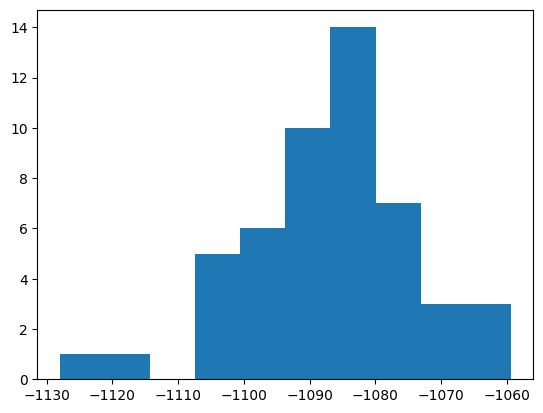

In [184]:
plt.hist(scores)

### 4.2.2. RFR

In [73]:
rfg_param_grid = {
    "rfg__n_estimators": [1, 10, 100, 1000],
    #"rfg__criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
    "rfg__criterion": ["squared_error"],
    "rfg__max_features": [1, "sqrt", "log2", None]
}

In [76]:
rfg = RandomForestRegressor(); scaler = StandardScaler()
pipe = Pipeline(steps=[("scaler", scaler), ("rfg", rfg)])
param_grid = rfg_param_grid

cv = KFold(n_splits = 5, shuffle = True)
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv = cv, scoring  = 'neg_mean_absolute_error')

In [84]:
sfs = SequentialFeatureSelector(
                 search, 
                 k_features= 10, 
                 forward = True, 
                 floating= True,
                 feature_groups = feature_groups,
                 verbose = 1,               
                 #scoring= my_scorer,
                 scoring = 'neg_mean_absolute_error',
                 cv = 5,
                 n_jobs = -1)

# fit the object to the training data
sfs = sfs.fit(ap_features[ap_size_var>0, :], ap_size_var[ap_size_var>0])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:  3.1min remaining:  6.9min
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:  3.2min finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.3min finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:  3.2min remaining:  5.6min
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:  3.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  2.8min finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:  3.2min remaining:   48.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | e

In [85]:
get_results_index(sfs, 10, toprint =  True)

['size_arr1' 'IN_degree' 'OUT_degree' 'within_group_OUT_degree'
 'within_comm_IN_degree' 'pagerank' 'betweeness' 'polarity_encoding'
 'comm_encoding' 'across_role']


([0, 1, 2, 4, 5, 7, 8, 9, 10, 12], -1190.8752477884616)

In [189]:
import pickle

count = np.zeros(13, dtype = int)
scores = []
indexs = []

for i in range(30):
    print(i)
    
    rfg = RandomForestRegressor(); scaler = StandardScaler()
    pipe = Pipeline(steps=[("scaler", scaler), ("rfg", rfg)])
    param_grid = rfg_param_grid

    cv = KFold(n_splits = 5, shuffle = True)
    search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv = cv, scoring  = 'neg_mean_absolute_error')
    
    sfs = SequentialFeatureSelector(
                 search, 
                 k_features= 10, 
                 forward = True, 
                 floating= True,
                 feature_groups = feature_groups,
                 verbose = 1,               
                 scoring = 'neg_mean_absolute_error',
                 cv = 5,
                 n_jobs = -1)
    sfs = sfs.fit(ap_features[ap_size_var>0, :], ap_size_var[ap_size_var>0])
    index, score = get_results_index(sfs, 10, toprint = False)
    with open("Results/SFS/RFR_" + str(i + 37), "wb") as fp:   #Pickling
        l = list(index) + list([score])
        pickle.dump(l, fp)
    scores.append(score)
    indexs.append(index)
    count[index] += 1

0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:  6.3min remaining: 14.1min
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:  6.5min finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  6.8min finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:  6.8min remaining: 11.8min
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:  7.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  5.8min finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:  6.5min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | e

1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:  6.1min remaining: 13.6min
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:  6.5min finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  6.5min finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:  6.7min remaining: 11.7min
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:  7.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  6.2min finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:  6.5min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | e

2


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:  6.1min remaining: 13.7min
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:  6.4min finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  6.6min finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:  6.4min remaining: 11.1min
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:  6.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  5.9min finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:  6.4min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | e

3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:  6.1min remaining: 13.8min
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:  6.4min finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  6.6min finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:  6.4min remaining: 11.1min
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:  6.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  5.9min finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:  6.5min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | e

4


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:  6.5min remaining: 14.7min
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:  6.8min finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  6.7min finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:  6.3min remaining: 11.0min
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:  6.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  5.9min finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:  6.5min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | e

5


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:  6.6min remaining: 14.9min
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:  7.0min finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  6.7min finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:  6.5min remaining: 11.4min
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:  6.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  5.9min finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:  6.5min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | e

6


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:  6.2min remaining: 14.0min
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:  6.5min finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  6.6min finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:  6.4min remaining: 11.2min
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:  6.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  5.9min finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:  6.5min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | e

7


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:  6.1min remaining: 13.8min
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:  6.3min finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  6.5min finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:  6.4min remaining: 11.2min
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:  6.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  6.0min finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:  6.8min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | e

8


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:  6.1min remaining: 13.8min
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:  6.4min finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  6.6min finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:  6.4min remaining: 11.3min
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:  6.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  6.0min finished
Features: 3/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:  6.6min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | e

9



STOPPING EARLY DUE TO KEYBOARD INTERRUPT...[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:  6.0min remaining: 13.5min
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:  6.2min finished
Features: 1/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  6.3min finished
Features: 2/10[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:  6.1min remaining: 10.7min
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:  6.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.

STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

KeyError: 10

In [197]:
import pickle

count = np.zeros(13, dtype = int)
scores = []
indexs = []

for i in range(50):
    with open("Results/SFS/RFR_" + str(i), "rb") as fp:   # Unpickling
        l = pickle.load(fp)
        index = l[:(-1)]
        score = l[-1]
    
    scores.append(score)
    indexs.append(index)
    count[index] += 1

In [198]:
feature_names = np.array(["size_arr1", "IN_degree", "OUT_degree", "within_group_IN_degree", "within_group_OUT_degree", "within_comm_IN_degree", "within_comm_OUT_degree", "pagerank", "betweeness", "polarity_encoding", "comm_encoding", "within_role", "across_role"])
for i in range(13):
    print(feature_names[i] + ":", count[i])

size_arr1: 50
IN_degree: 41
OUT_degree: 42
within_group_IN_degree: 29
within_group_OUT_degree: 50
within_comm_IN_degree: 39
within_comm_OUT_degree: 37
pagerank: 40
betweeness: 38
polarity_encoding: 48
comm_encoding: 28
within_role: 21
across_role: 36


(array([ 1.,  1.,  2.,  2., 17.,  9.,  9.,  6.,  1.,  2.]),
 array([-1248.77362005, -1236.51403794, -1224.25445583, -1211.99487372,
        -1199.73529161, -1187.4757095 , -1175.21612738, -1162.95654527,
        -1150.69696316, -1138.43738105, -1126.17779894]),
 <BarContainer object of 10 artists>)

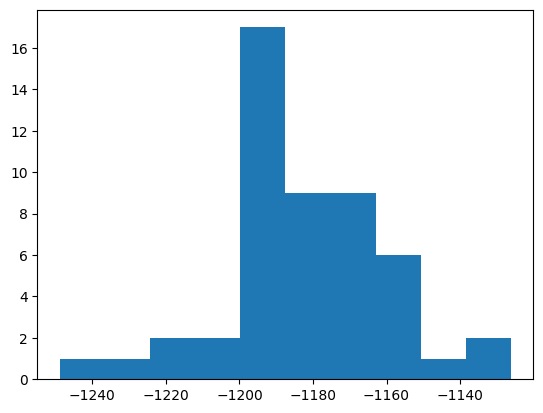

In [199]:
plt.hist(scores)